In [1]:
# does everybody really die in the summer?

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [29]:
# importing data
shots = pd.read_csv('data/boston_shots_fired.csv')
shots.head()

,incident_num,shooting_date,district,shooting_type_v2,victim_gender,victim_race,victim_ethnicity_NIBRS,multi_victim
0,I152000196-00,2015-01-01 13:30:00+00,C11,Non-Fatal,Male,Black or African American,Not Hispanic or Latinx,f
1,I152000879-00,2015-01-04 01:58:00+00,E18,Non-Fatal,Male,Black or African American,Not Hispanic or Latinx,f
2,I152001014-00,2015-01-04 18:52:00+00,E5,Non-Fatal,Male,Black or African American,Not Hispanic or Latinx,f
3,I152002232-00,2015-01-08 22:45:00+00,B2,Non-Fatal,Male,Black or African American,Not Hispanic or Latinx,t
4,I152002233-00,2015-01-08 22:45:00+00,B2,Non-Fatal,Female,Black or African American,Not Hispanic or Latinx,t


In [3]:
# cleaning up shots data

# we don't need the incident number for now
shots = shots.drop(columns=['incident_num'])

# converting the incident date to a datetime object
shots['incident_date'] = pd.to_datetime(shots['incident_date'])
shots['incident_date'] = shots['incident_date'].dt.date
shots['incident_date'] = pd.to_datetime(shots['incident_date'])

# converting t and f to 1 and 0, since this will be summed up by day later
shots['ballistics_evidence'] = shots['ballistics_evidence'].replace(['t', 'f'], [1, 0])

In [4]:
# adding an incident_count column, one for each occurence
shots['incident_count'] = 1

# grouping by day and sum only the incident_count column
shots_daily = shots.groupby(['incident_date']).sum().reset_index()

In [5]:
# read in weather data in 3 parts because of limitations on the NOAA API
weather1 = pd.read_csv('data/bos_weather_2015_2017.csv')
weather2 = pd.read_csv('data/bos_weather_2018_2020.csv')
weather3 = pd.read_csv('data/bos_weather_2021_2023.csv')

weather = pd.concat([weather1, weather2, weather3])

# isolating the columns we want
weather = weather[['DATE', 'AWND', 'PRCP', 'SNOW', 'TAVG']]
weather['DATE'] = pd.to_datetime(weather['DATE'])

In [6]:
# merging the shots data with the weather data

# adding the shots data to the weather data
# we want to merge the shots into the weather data
# because we want an entry for every single day, even if there were no shots
weather = weather.merge(shots_daily, left_on='DATE', right_on='incident_date', how='left')

# dropping the incident_date column now that we've merged
weather = weather.drop(columns=['incident_date'])

# rewriting weather data to a new variable we'll use for now
shots_daily = weather

# replacing NaNs with 0s in the incident_count column
shots_daily['incident_count'] = shots_daily['incident_count'].fillna(0)

In [7]:
shots_daily.head()

,DATE,AWND,PRCP,SNOW,TAVG,district,ballistics_evidence,incident_count
0,2015-01-01,14.32,0.00,0.0,26,C11A15,0.0,2.0
1,2015-01-02,12.75,0.00,0.0,34,B3E13,1.0,2.0
2,2015-01-03,10.29,0.62,1.4,28,B2,0.0,1.0
3,2015-01-04,8.28,0.57,0.0,38,B2B2,1.0,2.0
4,2015-01-05,22.15,0.00,0.0,40,C6,0.0,1.0


In [8]:
# let's create a new dataframe which tracks incidents per week
shots_weekly = shots_daily.resample('W-Mon', on='DATE').sum().reset_index().sort_values(by='DATE')

shots_weekly.head()

,DATE,AWND,PRCP,SNOW,TAVG,district,ballistics_evidence,incident_count
0,2015-01-05,67.79,1.19,1.4,166,C11A15B3E13B2B2B2C6,2.0,8.0
1,2015-01-12,83.67,0.23,0.4,145,B3B3A1C11C11B2B2B3A1A7E18,5.0,11.0
2,2015-01-19,80.52,0.27,0.8,189,B2B2B2B2B3D4D4B2B3E18B2E5C11B3,7.0,14.0
3,2015-01-26,78.29,0.81,7.4,208,B3C11B2A7B2E13B2B2B3C6,5.0,10.0
4,2015-02-02,102.91,1.85,40.5,144,E18B3A15B3B3B2B3C11A7E13,1.0,10.0


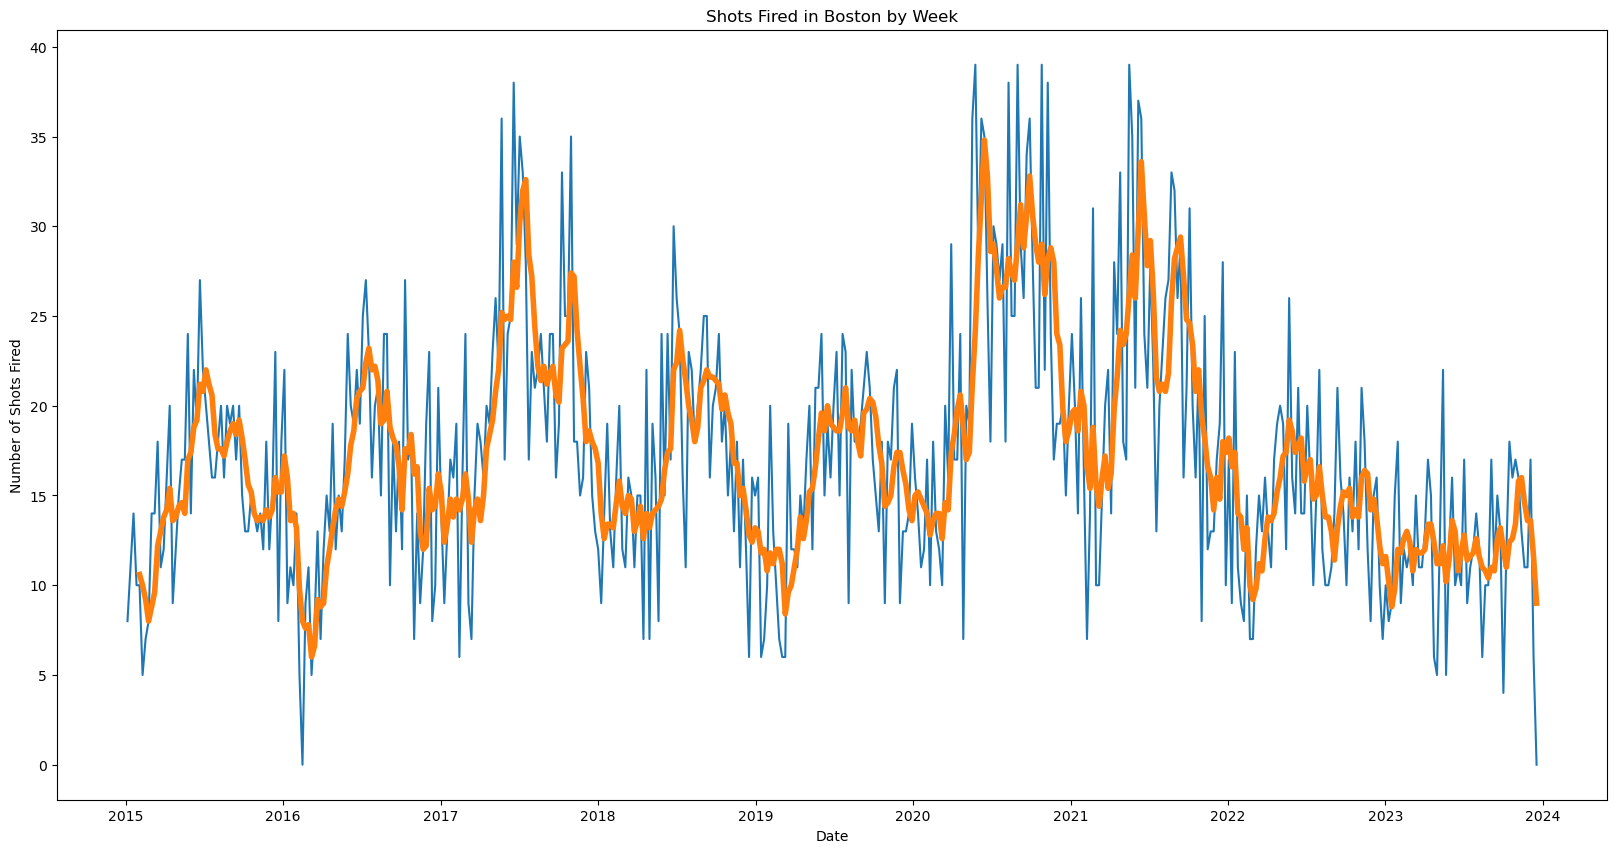

In [9]:
# let's add a moving average to the plot with a thicker line
plt.figure(figsize=(20,10))
plt.plot(shots_weekly['DATE'], shots_weekly['incident_count'])
plt.plot(shots_weekly['DATE'], shots_weekly['incident_count'].rolling(5).mean(), linewidth=4)
plt.title('Shots Fired in Boston by Week')
plt.xlabel('Date')
plt.ylabel('Number of Shots Fired')
plt.show()

In [10]:
# we can also calculate the number of daylight hours per day.
# but as much as i'd like to take credit for the math in the function below, i cant.
# so thanks to jake vanderplas for the code below.

import datetime
def hours_of_daylight(date, latitude=42.36):
    """Compute the hours of daylight for the given date"""
    diff = date - datetime.datetime(date.year, 1, 1)
    day_of_year = diff.days + float(diff.seconds) / (24 * 60 * 60)
    days_in_year = 365.2425  # average number of days in a year, accounting for leap years
    axial_tilt = 23.44  # axial tilt of the Earth

    # Calculate the declination angle
    declination = axial_tilt * np.sin(np.radians(360.0 * (day_of_year + 10) / days_in_year))

    # Calculate the hour angle
    hour_angle = np.arccos(-np.tan(np.radians(latitude)) * np.tan(np.radians(declination)))

    # Calculate the daylight hours
    daylight_hours = 2 * np.degrees(hour_angle) / 15

    return daylight_hours

# let's add the hours of daylight to the dataframe
shots_weekly['daylight_hours'] = list(map(hours_of_daylight, shots_weekly['DATE']))

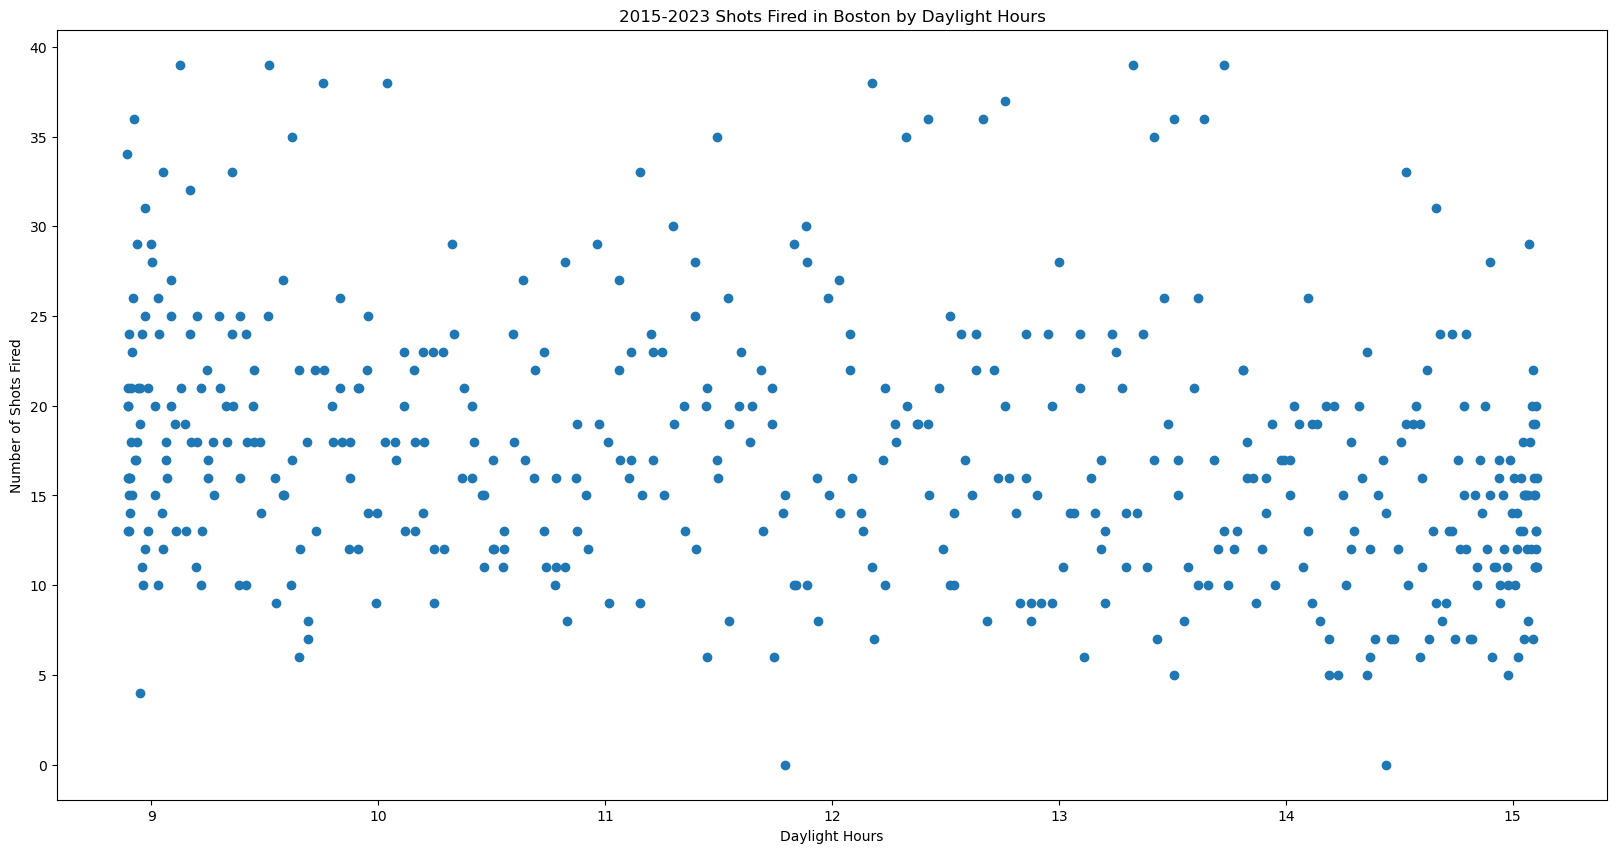

In [11]:
shots_weekly = shots_weekly[['DATE', 'incident_count', 'daylight_hours']]
shots_weekly.head()

# let's plot the number of shots fired against the number of daylight hours
plt.figure(figsize=(20,10))
plt.scatter(shots_weekly['daylight_hours'], shots_weekly['incident_count'])
plt.title('2015-2023 Shots Fired in Boston by Daylight Hours')
plt.xlabel('Daylight Hours')
plt.ylabel('Number of Shots Fired')
plt.show()


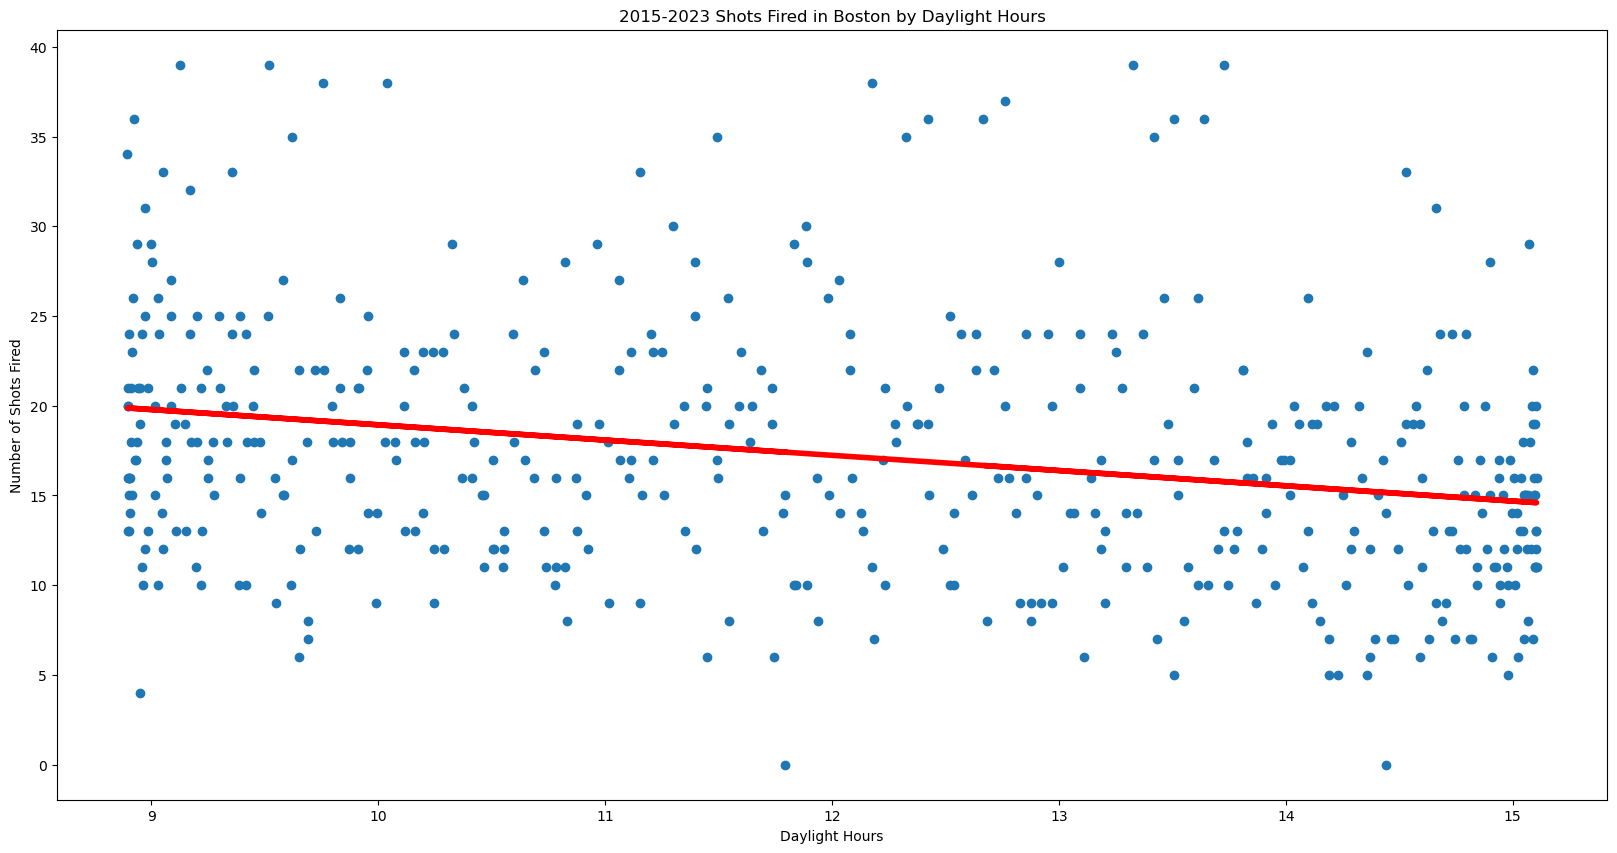

Coefficients: 
 [[-0.84949731]]
Intercept: 
 [27.43258819]
R-squared: 
 0.0659636114199389


In [12]:
# let's try to fit a line to this data with linear regression
from sklearn.linear_model import LinearRegression

# we need to reshape the data for sklearn
daylight_hours = shots_weekly['daylight_hours'].values.reshape(-1, 1)
incident_count = shots_weekly['incident_count'].values.reshape(-1, 1)

# creating the model
model = LinearRegression()
model.fit(daylight_hours, incident_count)

# let's plot the data and the line of best fit
plt.figure(figsize=(20,10))
plt.scatter(daylight_hours, incident_count)
plt.plot(daylight_hours, model.predict(daylight_hours), color='red', linewidth=4)
plt.title('2015-2023 Shots Fired in Boston by Daylight Hours')
plt.xlabel('Daylight Hours')
plt.ylabel('Number of Shots Fired')
plt.show()

# let's print the coefficients
print('Coefficients: \n', model.coef_)
print('Intercept: \n', model.intercept_)
print('R-squared: \n', model.score(daylight_hours, incident_count))

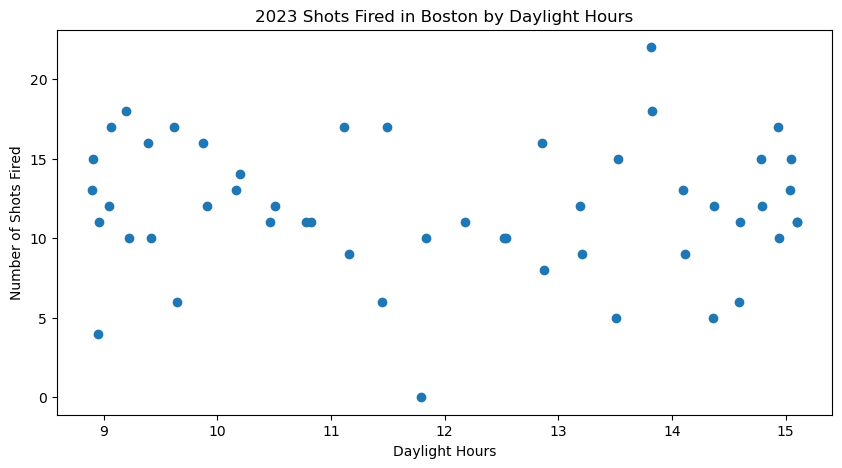

In [13]:
weekly_2023 = shots_weekly[shots_weekly['DATE'] > '2023-01-01']

plt.figure(figsize=(10,5))
plt.scatter(weekly_2023['daylight_hours'], weekly_2023['incident_count'])
plt.title('2023 Shots Fired in Boston by Daylight Hours')
plt.xlabel('Daylight Hours')
plt.ylabel('Number of Shots Fired')
plt.show()


In [14]:
# read in weather data in 3 parts because of limitations on the NOAA API
weather1 = pd.read_csv('data/bos_weather_2015_2017.csv')
weather2 = pd.read_csv('data/bos_weather_2018_2020.csv')
weather3 = pd.read_csv('data/bos_weather_2021_2023.csv')

weather = pd.concat([weather1, weather2, weather3])

# isolating the columns we want
weather = weather[['DATE', 'AWND', 'PRCP', 'SNOW', 'TAVG']]
weather['DATE'] = pd.to_datetime(weather['DATE'])

# converting weather to a weekly dataframe
weather_weekly = weather.resample('W-Mon', on='DATE').mean().reset_index().sort_values(by='DATE')
weather_weekly = weather_weekly[['DATE', 'PRCP', 'TAVG']]

In [15]:
weather_weekly.head()

,DATE,PRCP,TAVG
0,2015-01-05,0.238000,33.200000
1,2015-01-12,0.032857,20.714286
2,2015-01-19,0.038571,27.000000
3,2015-01-26,0.115714,29.714286
4,2015-02-02,0.264286,20.571429


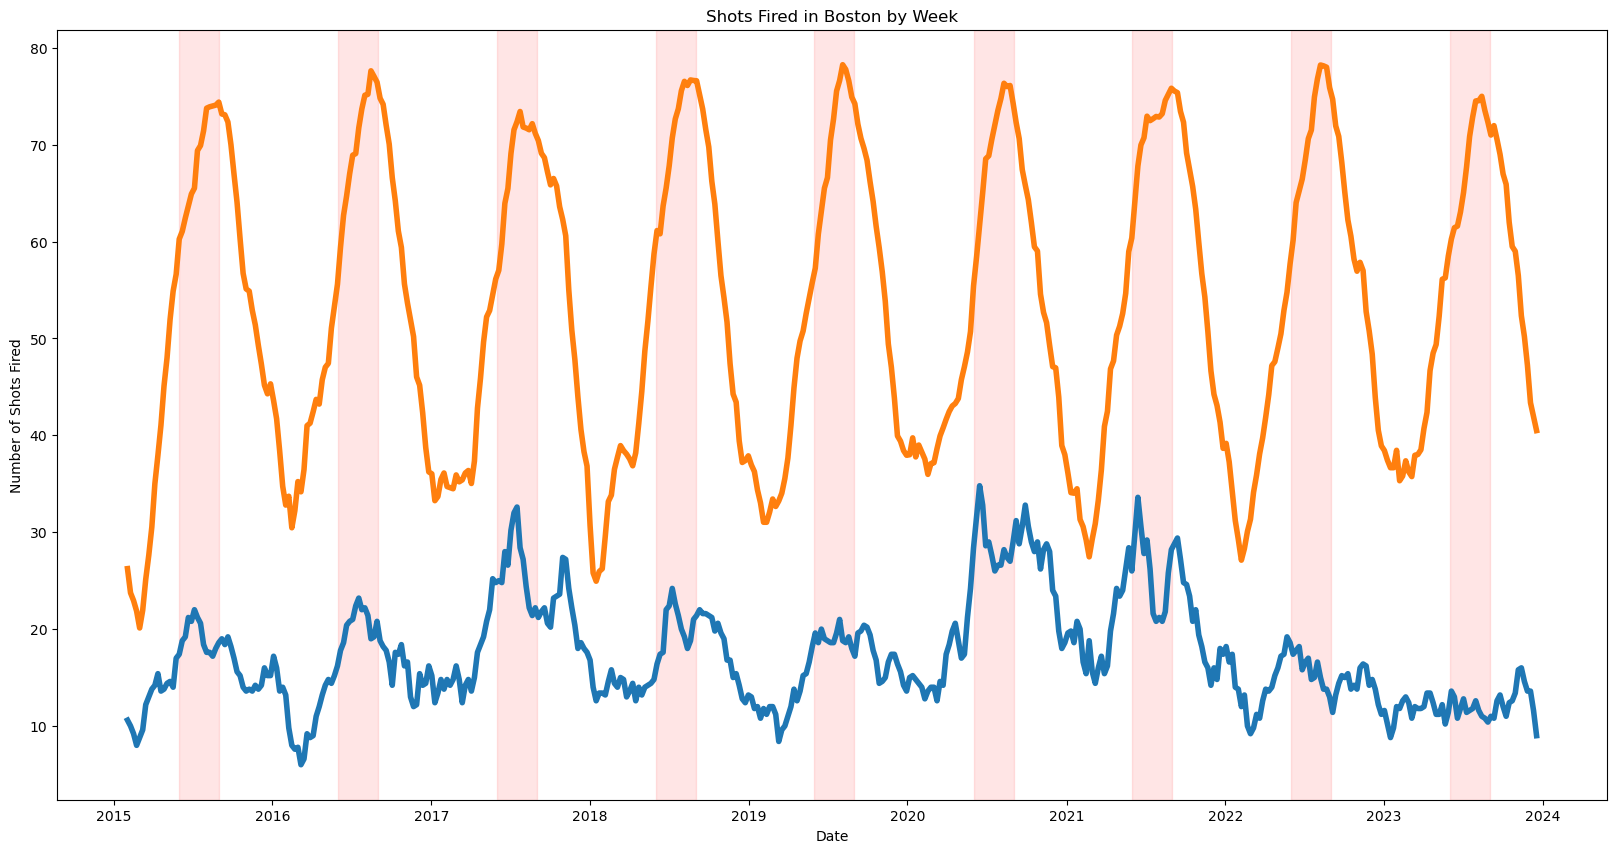

In [16]:
# plotting shots fired vs average temperature
plt.figure(figsize=(20,10))
plt.plot(shots_weekly['DATE'], shots_weekly['incident_count'].rolling(5).mean(), linewidth=4)
plt.plot(weather_weekly['DATE'], weather_weekly['TAVG'].rolling(5).mean(), linewidth=4)
plt.title('Shots Fired in Boston by Week')
plt.xlabel('Date')
plt.ylabel('Number of Shots Fired')

# plotting the summer months in as vertical red bars
plt.axvspan('2015-06-01', '2015-09-01', color='red', alpha=0.1)
plt.axvspan('2016-06-01', '2016-09-01', color='red', alpha=0.1)
plt.axvspan('2017-06-01', '2017-09-01', color='red', alpha=0.1)
plt.axvspan('2018-06-01', '2018-09-01', color='red', alpha=0.1)
plt.axvspan('2019-06-01', '2019-09-01', color='red', alpha=0.1)
plt.axvspan('2020-06-01', '2020-09-01', color='red', alpha=0.1)
plt.axvspan('2021-06-01', '2021-09-01', color='red', alpha=0.1)
plt.axvspan('2022-06-01', '2022-09-01', color='red', alpha=0.1)
plt.axvspan('2023-06-01', '2023-09-01', color='red', alpha=0.1)

plt.show()

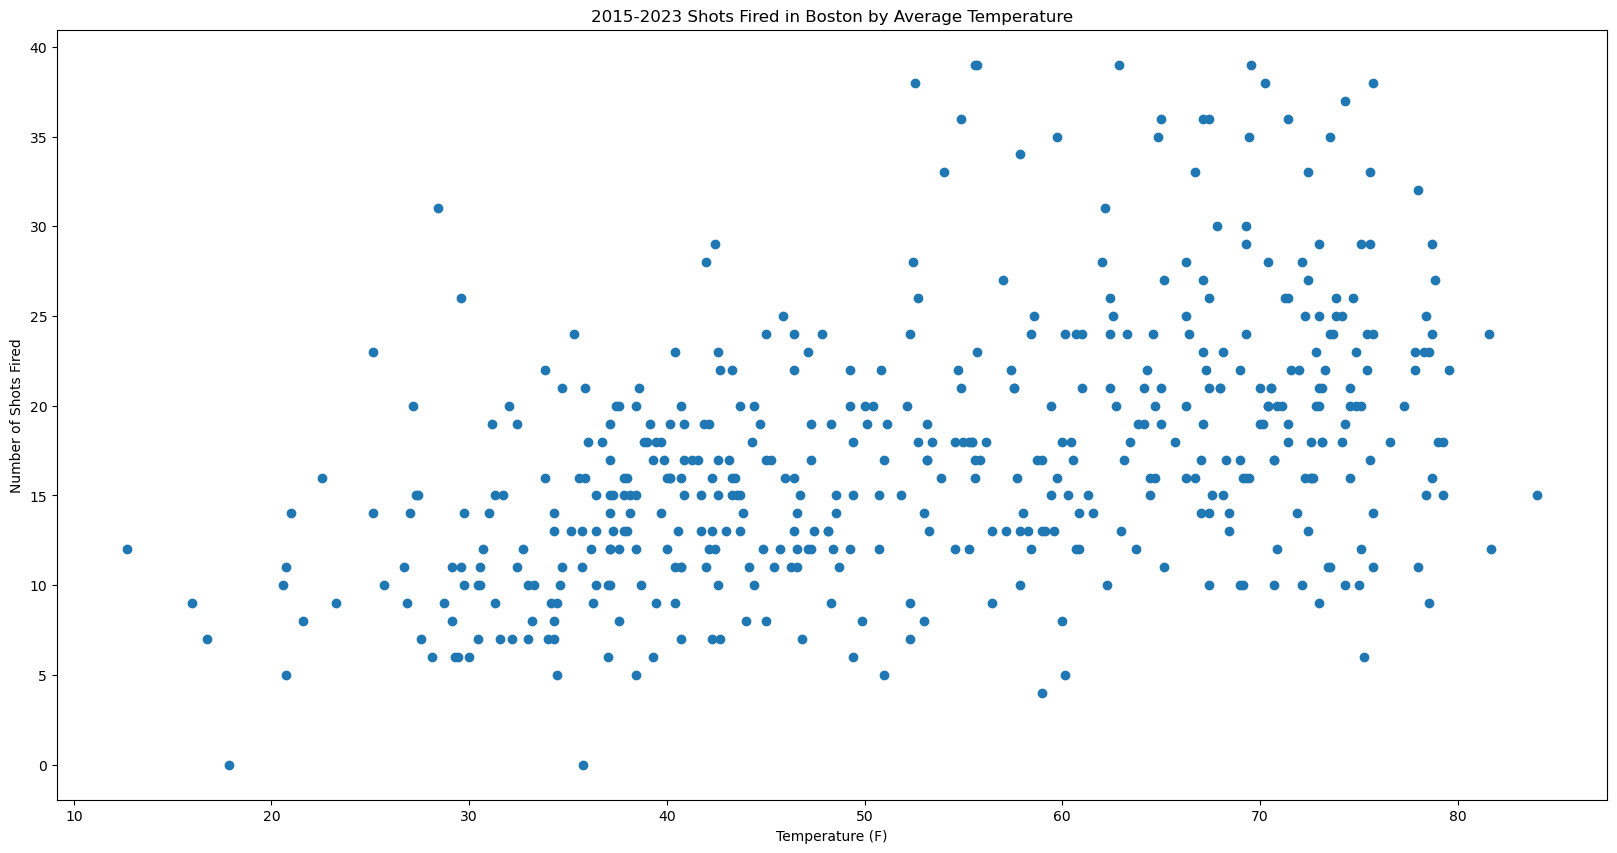

In [17]:
# let's plot the number of shots fired against the number of daylight hours
plt.figure(figsize=(20,10))
plt.scatter(weather_weekly['TAVG'], shots_weekly['incident_count'])
plt.title('2015-2023 Shots Fired in Boston by Average Temperature')
plt.xlabel('Temperature (F)')
plt.ylabel('Number of Shots Fired')
plt.show()

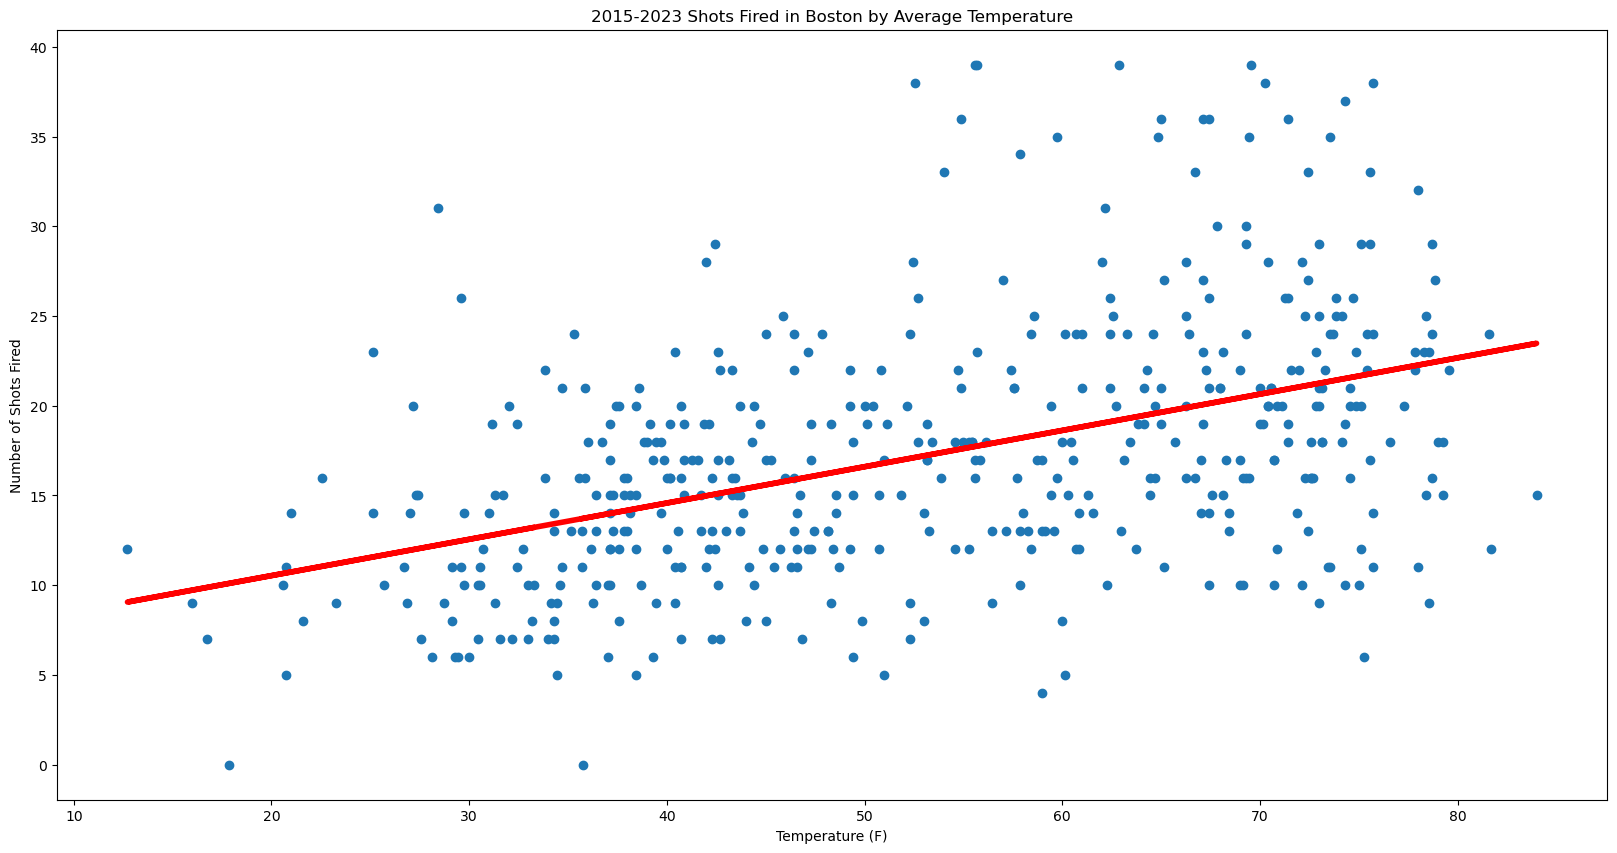

Coefficients: 
 [[0.20218485]]
Intercept: 
 [6.49311428]
R-squared: 
 0.20809101401832897


In [18]:
# let's try to fit a line to this data with linear regression

# we need to reshape the data for sklearn
temp = weather_weekly['TAVG'].values.reshape(-1, 1)
incident_count = shots_weekly['incident_count'].values.reshape(-1, 1)

# creating the model
model = LinearRegression()
model.fit(temp, incident_count)

# let's plot the data and the line of best fit
plt.figure(figsize=(20,10))
plt.scatter(temp, incident_count)
plt.plot(temp, model.predict(temp), color='red', linewidth=4)
plt.title('2015-2023 Shots Fired in Boston by Average Temperature')
plt.xlabel('Temperature (F)')
plt.ylabel('Number of Shots Fired')
plt.show()

# let's print the coefficients
print('Coefficients: \n', model.coef_)
print('Intercept: \n', model.intercept_)
print('R-squared: \n', model.score(temp, incident_count))

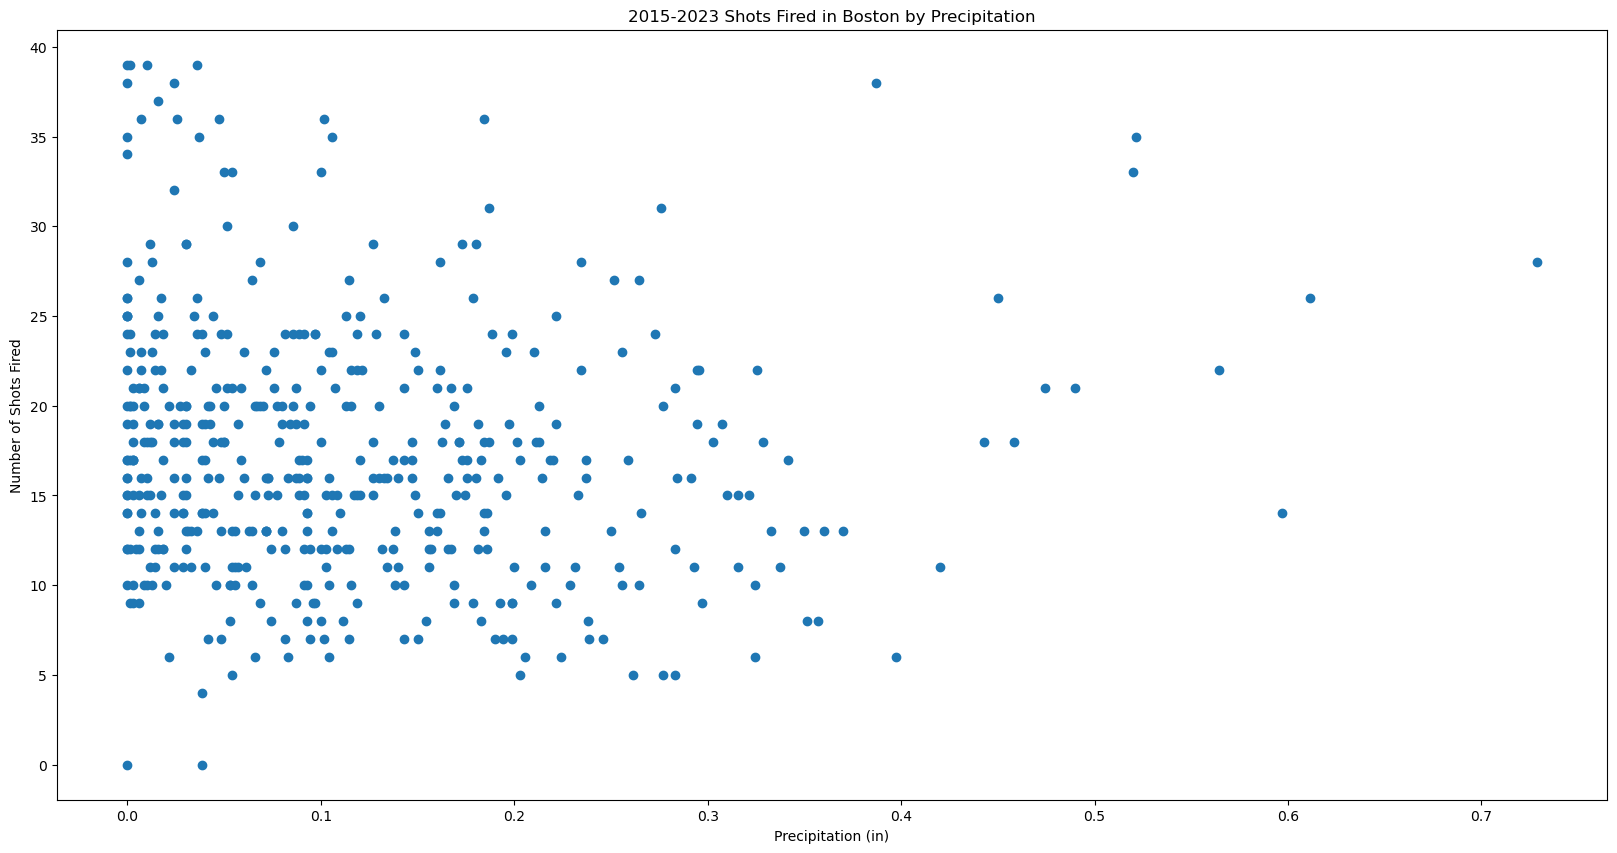

In [19]:
# let's do the same but for precipitation
plt.figure(figsize=(20,10))
plt.scatter(weather_weekly['PRCP'], shots_weekly['incident_count'])
plt.title('2015-2023 Shots Fired in Boston by Precipitation')
plt.xlabel('Precipitation (in)')
plt.ylabel('Number of Shots Fired')
plt.show()

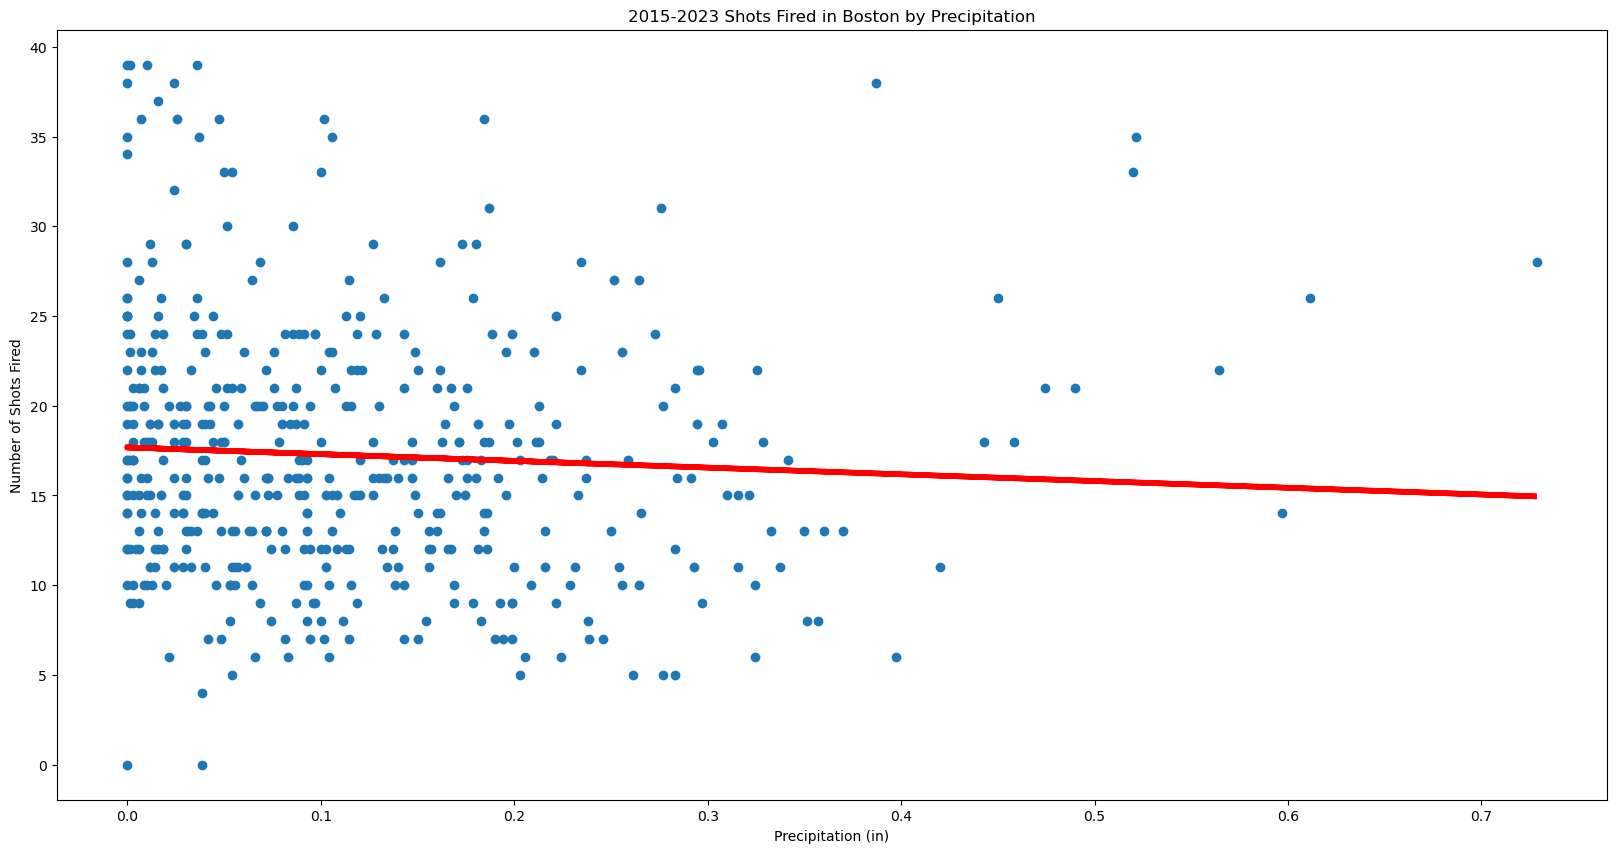

Coefficients: 
 [[-3.74595695]]
Intercept: 
 [17.67781503]
R-squared: 
 0.0035510320615801394


In [27]:
# now let's try to fit a line to this data with linear regression

# we need to reshape the data for sklearn
precip = weather_weekly['PRCP'].values.reshape(-1, 1)
incident_count = shots_weekly['incident_count'].values.reshape(-1, 1)

# creating the model
model = LinearRegression()
model.fit(precip, incident_count)

# let's plot the data and the line of best fit
plt.figure(figsize=(20,10))
plt.scatter(precip, incident_count)
plt.plot(precip, model.predict(precip), color='red', linewidth=4)
plt.title('2015-2023 Shots Fired in Boston by Precipitation')
plt.xlabel('Precipitation (in)')
plt.ylabel('Number of Shots Fired')
plt.show()

# let's print the coefficients
print('Coefficients: \n', model.coef_)
print('Intercept: \n', model.intercept_)
print('R-squared: \n', model.score(precip, incident_count))

- Currently, daylight hours isn't a driving force in shots fired, but temp seems to be

In [21]:
# plt.scatter(shots_daily['daylight_hours'], shots_daily['incident_count'], alpha=0.1)
# plt.xlabel('hours of daylight')
# plt.ylabel('incident count')

# # very interesting. on first glance, the hours of daylight doesn't seem to
# # have much of a correlation with the incident count
# # this sort of makes sense, as you may imagine that illegal activity might occur
# # more often at night, when there is less daylight